# A simple example of SVD for recommendation

**Note: Before running this, have a read through. Some of the discussion is based on my particular randomly generated data**

In [1]:
import pandas as pd
import numpy as np

First, let's generate a really simple data set. Each row is a user, and each column is an item. If the value for a user:item location is 1; that user has "liked" that item on _SocialMediaster-SellingMaster<sup>TM</sup>_, my new social media platform for people who like items and things and stuff.

In [2]:
num_users = 10
num_items = 5
np.random.seed(42)
def generate_users(num_users, num_items):
    data = []
    for i in range(num_users):
        user = [np.random.randint(2) for _ in range(num_items)]
        data.append(user)
    return data
cols = ["item"+str(i) for i in range(num_items)]
rows = ["user"+str(i) for i in range(num_users)]
user_item_mat = pd.DataFrame(generate_users(num_users,num_items), columns=cols)
user_item_mat.index = rows
user_item_mat         

,item0,item1,item2,item3,item4
user0,0,1,0,0,0
user1,1,0,0,0,1
user2,0,0,0,0,1
user3,0,1,1,1,0
user4,1,0,1,1,1
user5,1,1,1,1,1
user6,0,0,1,1,1
user7,0,1,0,0,0
user8,0,0,1,1,1
user9,1,1,0,1,1


Now, let's do some SVD. This is a small enough dataset that I really don't need to truncate... but in most large scale recommenders you WILL need to truncate, so we're going to start with only 3 components of SVD. 

In [3]:
from scipy.linalg import svd

U, Sigma, VT = svd(user_item_mat)

As a reminder, here's what we're expecting to see:

<img src="http://zwmiller.com/projects/images/svd_breakdown.png">

Great, so now what do we have? In this case **VT** is now a matrix where each column represents one of the items in the new vector space. Each row is one component of the vector space, for the items.

In [4]:
VT = VT[:3,:]
pd.DataFrame(VT)

,0,1,2,3,4
0,-0.354165,-0.308102,-0.443679,-0.535715,-0.543874
1,0.073549,-0.894073,0.074189,-0.036512,0.434037
2,-0.623270,-0.172861,0.598433,0.344539,-0.323766


If I transpose this, the rows are items, and the columns are the items in the "hidden" vector space created by the truncated SVD.

In [5]:
pd.DataFrame(VT.T)

,0,1,2
0,-0.354165,0.073549,-0.623270
1,-0.308102,-0.894073,-0.172861
2,-0.443679,0.074189,0.598433
3,-0.535715,-0.036512,0.344539
4,-0.543874,0.434037,-0.323766


**U** is a matrix where each row is a user and each column shows the location in the hidden vector space created by the SVD.

In [6]:
U = U[:,:3]
pd.DataFrame(U)

,0,1,2
0,-0.070822,-0.457381,-0.098917
1,-0.206427,0.259666,-0.541928
2,-0.125017,0.222040,-0.185270
3,-0.295950,-0.438107,0.440685
4,-0.431556,0.278940,-0.002326
5,-0.502377,-0.178441,-0.101243
6,-0.350146,0.241314,0.354332
7,-0.070822,-0.457381,-0.098917
8,-0.350146,0.241314,0.354332
9,-0.400391,-0.216394,-0.443688


**Sigma** is just the singular values of the decomposition. In this case, we're not particularly interested in **Sigma**.

In [7]:
Sigma = Sigma[:3]
pd.DataFrame(np.diag(Sigma))

,0,1,2
0,4.350384,0.000000,0.000000
1,0.000000,1.954766,0.000000
2,0.000000,0.000000,1.747531


## Simple example with named entities to show this method works

In [35]:
import pandas as pd
data = [[5,4,5,0,0,0],[3,3,3,0,0,0],[5,5,5,0,0,0],[4,5,4,0,0,0],[0,0,0,3,3,3],[0,0,0,5,5,5],[0,0,0,4,5,4],[0,0,0,0,0,0]]
df = pd.DataFrame(data)

In [36]:
cols = ['Star Wars', 'Star Trek', 'Space Balls', 'Diehard','Lethal Weapon', 'Terminator']
rows = ["user"+str(i) for i in range(8)]
df.index = rows
df.columns = cols
df

,Star Wars,Star Trek,Space Balls,Diehard,Lethal Weapon,Terminator
user0,5,4,5,0,0,0
user1,3,3,3,0,0,0
user2,5,5,5,0,0,0
user3,4,5,4,0,0,0
user4,0,0,0,3,3,3
user5,0,0,0,5,5,5
user6,0,0,0,4,5,4
user7,0,0,0,0,0,0


In [37]:
from scipy.linalg import svd

U_test, Sigma_test, VT_test = svd(df)
VT_test = VT_test[:2,:]
U_test = U_test[:,:2]

In [38]:
movie_concept_test = pd.DataFrame(VT_test, columns=cols)
movie_concept_test.T

,0,1
Star Wars,-0.578215,0.000000
Star Trek,-0.575618,0.000000
Space Balls,-0.578215,0.000000
Diehard,0.000000,-0.561084
Lethal Weapon,0.000000,-0.608580
Terminator,0.000000,-0.561084


In [39]:
user_concept_test = pd.DataFrame(U_test, index=rows)

In [40]:
user_concept_test

,0,1
user0,-0.540577,0.000000
user1,-0.347440,0.000000
user2,-0.579066,0.000000
user3,-0.501741,0.000000
user4,0.000000,-0.412328
user5,0.000000,-0.687214
user6,0.000000,-0.598100
user7,0.000000,0.000000


## Now back to our normal data

Now, let's take a look at the matrix again. 

Let's note a few things (assuming you are still looking at my data and haven't re-run anything yet):
 * Items 0 and 4 have a lot of overlapping users. Users that like Item 2, tend to also like Item 3.
 * Users 6 and 8 like exactly the same items.

In [14]:
user_item_mat

,item0,item1,item2,item3,item4
user0,0,1,0,0,0
user1,1,0,0,0,1
user2,0,0,0,0,1
user3,0,1,1,1,0
user4,1,0,1,1,1
user5,1,1,1,1,1
user6,0,0,1,1,1
user7,0,1,0,0,0
user8,0,0,1,1,1
user9,1,1,0,1,1


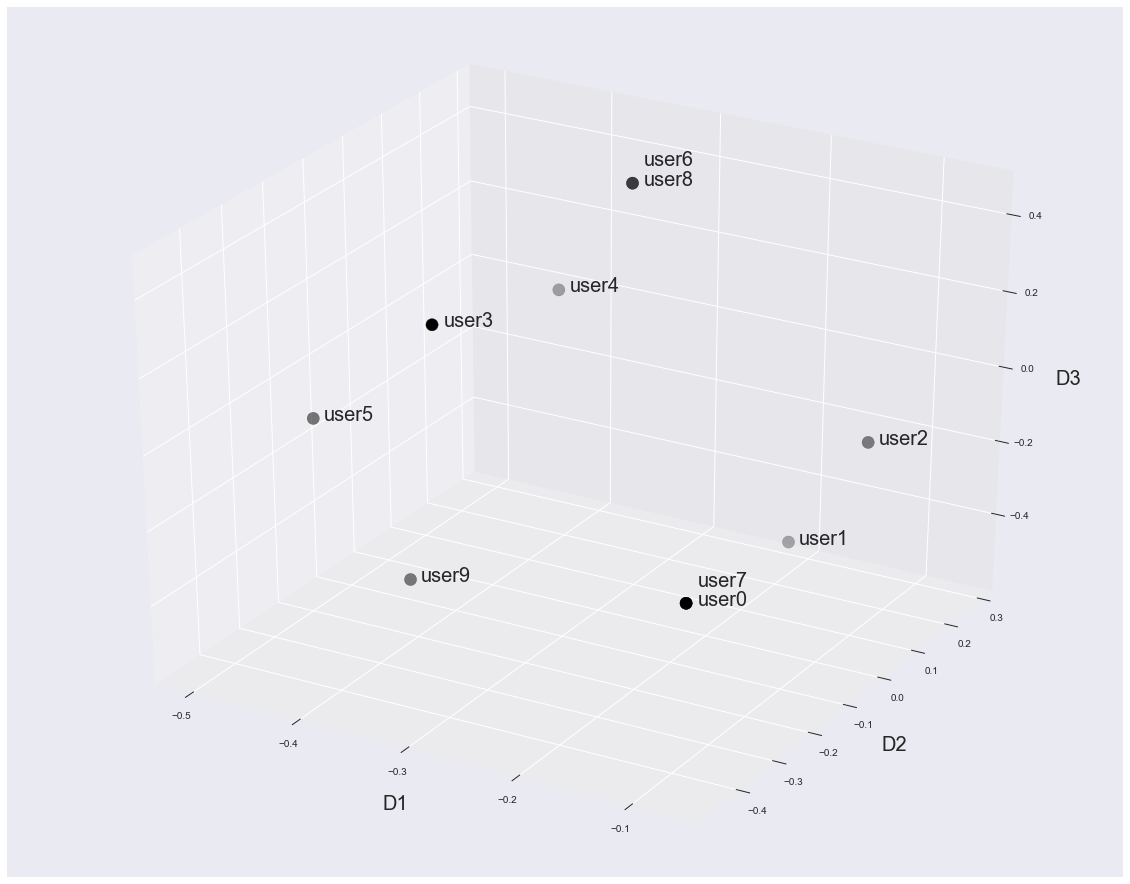

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
plt.style.use('seaborn')

fig = plt.figure(figsize=(20,16))
ax = fig.gca(projection='3d')
ax.scatter(U[:,0],U[:,1],U[:,2],c='k',s=150);
ax.set_xlabel("D1", fontsize=20, labelpad=20)
ax.set_ylabel("D2", fontsize=20, labelpad=20)
ax.set_zlabel("D3", fontsize=20, labelpad=20);

lbls = user_item_mat.index
offset = 0.01
for i, txt in enumerate(lbls):
    if i not in [6,7]:
        ax.text(U[i,0]+offset,U[i,1],U[i,2],txt, fontsize=20)
    else:
        ax.text(U[i,0]+offset,U[i,1],U[i,2]+5*offset,txt, fontsize=20)


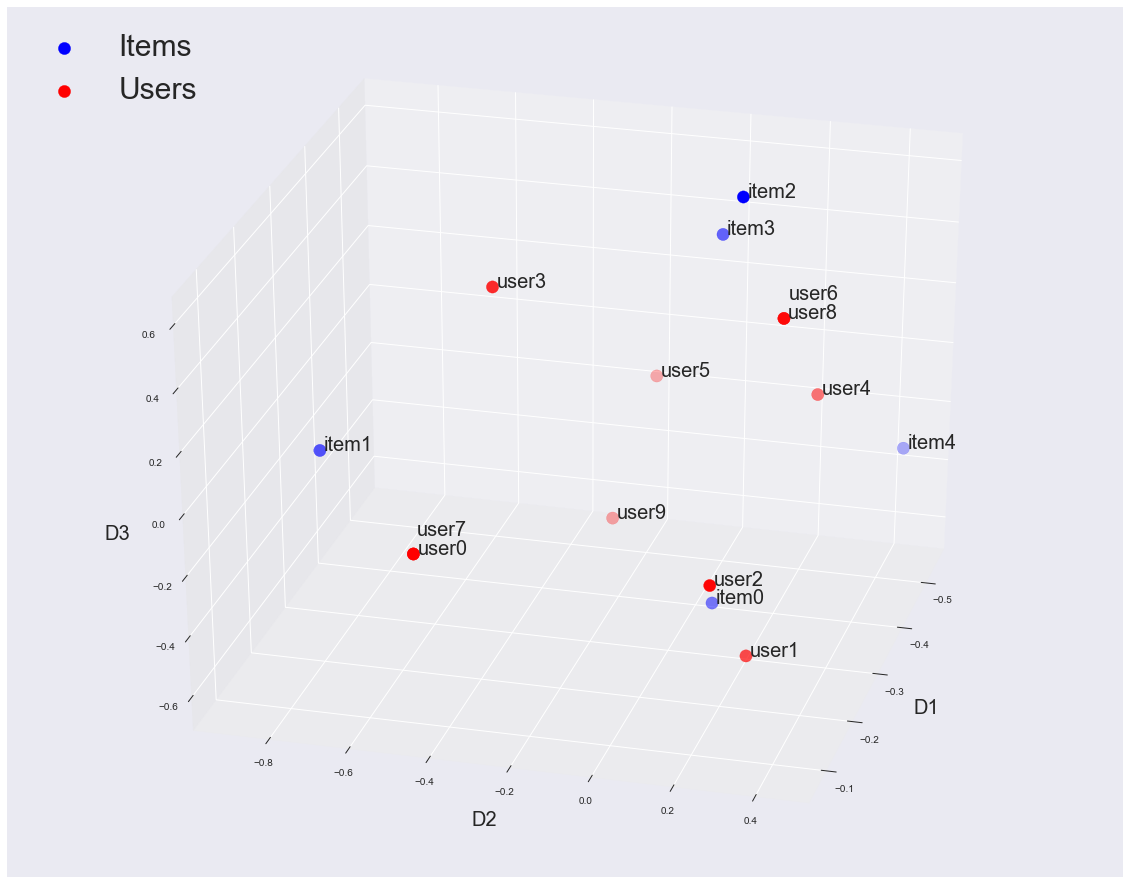

In [16]:
fig = plt.figure(figsize=(20,16))
ax = fig.gca(projection='3d')
ax.scatter(VT.T[:,0],VT.T[:,1],VT.T[:,2],c='b',s=150, label="Items");
ax.scatter(U[:,0],U[:,1],U[:,2],c='r',s=150, label="Users");
ax.set_xlabel("D1", fontsize=20, labelpad=20)
ax.set_ylabel("D2", fontsize=20, labelpad=20)
ax.set_zlabel("D3", fontsize=20, labelpad=20);

lbls = user_item_mat.columns
item_offset = 0.01
for i, txt in enumerate(lbls):
    if i not in [6,7]:
        ax.text(VT.T[i,0],VT.T[i,1]+item_offset,VT.T[i,2],txt, fontsize=20)
    else:
        ax.text(VT.T[i,0],VT.T[i,1]+item_offset,VT.T[i,2]+5*item_offset,txt, fontsize=20)

lbls = user_item_mat.index
offset = 0.01
for i, txt in enumerate(lbls):
    if i not in [6,7]:
        ax.text(U[i,0],U[i,1]+offset,U[i,2],txt, fontsize=20)
    else:
        ax.text(U[i,0],U[i,1]+offset,U[i,2]+6*offset,txt, fontsize=20)
ax.view_init(30,15)
plt.legend(loc="upper left", fontsize=30);

So, if we look in our new hidden vector space and take the dot products of items (cosine similarity!), we expect that items 2 & 3 are the most similar. 

In [12]:
compare_item = 2
for item in range(num_items):
    if item != compare_item:
        print("Item %s & %s: "%(compare_item,item), np.dot(VT.T[compare_item],VT.T[item]))

Item 2 & 0:  -0.21039350295933443
Item 2 & 1:  -0.033077064237217
Item 2 & 3:  0.4411602025458312
Item 2 & 4:  0.07975391765448048


If we compare users, we expect that users 6 & 8 should be the most similar.

In [13]:
compare_user = 6
for user in range(num_users):
    #if user != compare_user:
        print("User %s & %s: "%(compare_user,user), np.dot(U[compare_user],U[user]))

User 6 & 0:  6.938893903907228e-17
User 6 & 1:  -1.9081958235744878e-16
User 6 & 2:  -2.498001805406602e-16
User 6 & 3:  -3.122502256758253e-16
User 6 & 4:  0.0
User 6 & 5:  0.0
User 6 & 6:  0.9999999999999997
User 6 & 7:  0.0
User 6 & 8:  -1.5265566588595902e-16
User 6 & 9:  1.1102230246251565e-16


Let's make a function that returns recommendations for a given item input (this user likes item 0... so she'll probably also like items X, Y, Z).

In [14]:
def get_recommends(itemID, VT, num_recom=2):
    recs = []
    for item in range(VT.T.shape[0]):
        if item != itemID:
            recs.append([item,np.dot(VT.T[itemID],VT.T[item])])
    final_rec = [i[0] for i in sorted(recs,key=lambda x: x[1],reverse=True)]
    return final_rec[:num_recom]

print(get_recommends(2,VT,num_recom=2))

[3, 4]


We could also find a user that's most similar to a user and then recommend all items they like. In my example, user 3 is most similar to user 5... but user 5 also likes item 0 (and user 3 doesn't). Thus, this function will find for user 3 - User 5 is most similar, and item 0 should be something user 3 likes too.

In [20]:
def get_recommends_user(userID, U, df):
    userrecs = []
    for user in range(U.shape[0]):
        if user!= userID:
            userrecs.append([user,np.dot(U[userID],U[user])])
    final_rec = [i[0] for i in sorted(userrecs,key=lambda x: x[1],reverse=True)]
    comp_user = final_rec[0]
    print("User #%s's most similar user is User #%s "% (userID, comp_user))
    rec_likes = df.iloc[comp_user]
    current = df.iloc[userID]
    recs = []
    for i,item in enumerate(current):
        if item != rec_likes[i] and rec_likes[i]!=0:
            recs.append(i)
    return recs


print("Items for User %s to check out: "% user_to_rec, get_recommends_user(user_to_rec,U,user_item_mat))

User #3's most similar user is User #5 
Items for User 3 to check out:  [0, 4]


That's exactly what a recommender is doing for collaborative filtering, on a massive scale!

In [15]:
test_re = [[1,2,5,2],[2,5,3,1],[4,7,2,1]]

In [28]:
s1 = [1,3,5]

In [29]:
s2=[3]

In [30]:
np.setdiff1d(s1,s2)

array([1, 5])

In [23]:
results

[0, 0, 0, 0]

In [24]:
result = [sum(a) for a in zip(*test_re)]

In [25]:
result

[7, 14, 10, 4]

In [2]:
def get_recommends_similar_users(userIDs, U, n_reco = 10):
    users_to_rec = np.setdiff1d(list(range(U.shape[0])),userIDs)
    print(users_to_rec)
    user_sim_score = []
    
    for user in users_to_rec:
        user_sim_score.append(np.mean([np.dot(U[userid],U[user]) for userid in userIDs]))
        
    userrecs = zip(users_to_rec,user_sim_score)
    
    final_rec = [i[0] for i in sorted(userrecs,key=lambda x: x[1],reverse=True)]

    return final_rec[:n_reco]

In [3]:
get_recommends_similar_users(user_to_rec,U,user_item_mat)

NameError: name 'user_to_rec' is not defined

In [64]:
user_to_rec = np.array([3,5])

In [43]:
U.shape

(10, 10)

In [48]:
range(U.shape[0])

range(0, 10)

In [67]:
np.setdiff1d(l1,user_to_rec)

array([0, 1, 2, 4, 6, 7, 8, 9])

In [61]:
l1 = np.array(range(U.shape[0]))

In [65]:
type(user_to_rec[0])

numpy.int32

In [63]:
l1

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])